In [11]:
# --- SETUP ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyodbc

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from dotenv import load_dotenv
import os
import warnings
warnings.filterwarnings('ignore')


# Cargar archivo .env
# Ruta relativa desde el notebook hasta el .env
'''dotenv_path = '../generadores/.env'  #

# Cargar el archivo .env desde la ruta especificada
load_dotenv(dotenv_path=dotenv_path)

# Leer variables de entorno
username = os.getenv("USUARIO_DB")
password = os.getenv("CLAVE_BD")

# Validar que se cargaron bien
#print("Usuario:", username)
#print("Contraseña cargada:", bool(password))  # No imprime la clave, pero verifica si existe

if not username or not password:
    raise ValueError("Las variables de entorno USUARIO_DB o CLAVE_BD no están definidas")

# Cadena de conexión
conn_str = (
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=upgradeserver-vf.database.windows.net;'
    'DATABASE=Banco;'
    f'UID={username};'
    f'PWD={password};'
    'Connection Timeout=30;'
)

# Conexión
conn = pyodbc.connect(conn_str)'''



'dotenv_path = \'../generadores/.env\'  #\n\n# Cargar el archivo .env desde la ruta especificada\nload_dotenv(dotenv_path=dotenv_path)\n\n# Leer variables de entorno\nusername = os.getenv("USUARIO_DB")\npassword = os.getenv("CLAVE_BD")\n\n# Validar que se cargaron bien\n#print("Usuario:", username)\n#print("Contraseña cargada:", bool(password))  # No imprime la clave, pero verifica si existe\n\nif not username or not password:\n    raise ValueError("Las variables de entorno USUARIO_DB o CLAVE_BD no están definidas")\n\n# Cadena de conexión\nconn_str = (\n    \'DRIVER={ODBC Driver 17 for SQL Server};\'\n    \'SERVER=upgradeserver-vf.database.windows.net;\'\n    \'DATABASE=Banco;\'\n    f\'UID={username};\'\n    f\'PWD={password};\'\n    \'Connection Timeout=30;\'\n)\n\n# Conexión\nconn = pyodbc.connect(conn_str)'

In [12]:
'''usuarios = pd.read_sql_query("SELECT * FROM usuarios", conn)
creditos = pd.read_sql_query("SELECT * FROM creditos", conn)
activos_financieros = pd.read_sql_query("SELECT usuario_id, tipo_activo, monto FROM activos_financieros", conn)
monedas_digitales = pd.read_sql_query("SELECT * FROM monedas_digitales", conn)
cuentas_bancarias = pd.read_sql_query("SELECT * FROM cuentas_bancarias", conn)'''

'usuarios = pd.read_sql_query("SELECT * FROM usuarios", conn)\ncreditos = pd.read_sql_query("SELECT * FROM creditos", conn)\nactivos_financieros = pd.read_sql_query("SELECT usuario_id, tipo_activo, monto FROM activos_financieros", conn)\nmonedas_digitales = pd.read_sql_query("SELECT * FROM monedas_digitales", conn)\ncuentas_bancarias = pd.read_sql_query("SELECT * FROM cuentas_bancarias", conn)'

In [13]:
usuarios = pd.read_csv('../data/usuarios.csv')
creditos = pd.read_csv('../data/creditos.csv')
activos_financieros = pd.read_csv('../data/activo.csv')
cuentas = pd.read_csv('../data/cuenta.csv')
monedas_digitales = pd.read_csv('../data/moneda.csv')

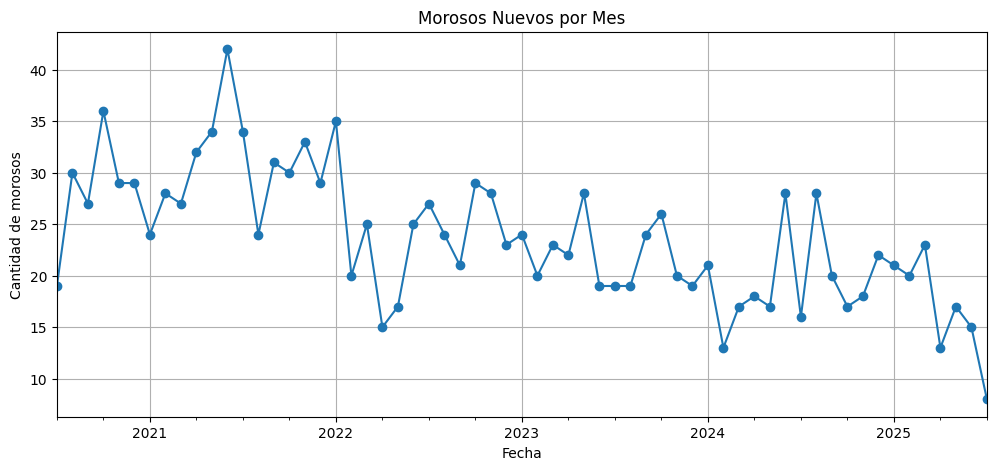


📉 Predicción de morosos nuevos para los próximos 6 meses:
       fecha  pred
0 2025-07-31  16.0
1 2025-08-31  16.0
2 2025-09-30  16.0
3 2025-10-31  15.0
4 2025-11-30  15.0
5 2025-12-31  15.0


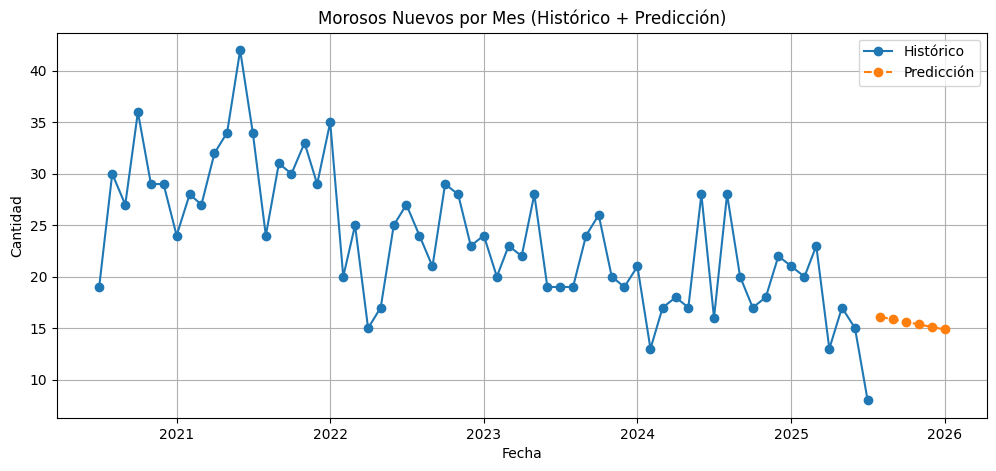

In [14]:
from sklearn.linear_model import LinearRegression
from pandas.tseries.offsets import MonthEnd

# --- PREDICCIÓN DE MOROSOS NUEVOS POR MES ---

# Asegurarse de que la fecha esté bien formateada
creditos['fecha_inicio'] = pd.to_datetime(creditos['fecha_inicio'], errors='coerce')

# Tomar el primer crédito de cada usuario
primer_credito_morosidad = creditos.sort_values('fecha_inicio').drop_duplicates('usuario_id')

# Unir con la tabla de usuarios usando usuario_id
primer_credito_morosidad = primer_credito_morosidad.merge(
    usuarios[['id', 'es_moroso']],
    left_on='usuario_id',
    right_on='id',
    how='left'
)

# Agrupar morosos nuevos por mes
morosos_por_mes = (
    primer_credito_morosidad[primer_credito_morosidad['es_moroso'] == 1]
    .groupby(primer_credito_morosidad['fecha_inicio'].dt.to_period('M'))
    .size()
    .to_timestamp()
)

# Visualización histórica
morosos_por_mes.plot(marker='o', figsize=(12, 5), title='Morosos Nuevos por Mes')
plt.grid(True)
plt.ylabel("Cantidad de morosos")
plt.xlabel("Fecha")
plt.show()

# Preparar datos para regresión
df_morosos = morosos_por_mes.reset_index()
df_morosos.columns = ['fecha', 'morosos']
df_morosos['mes_num'] = np.arange(len(df_morosos))

# Modelo de regresión lineal
modelo_morosos = LinearRegression()
modelo_morosos.fit(df_morosos[['mes_num']], df_morosos['morosos'])

# Predicción para los próximos 6 meses
futuro_morosos = pd.DataFrame({'mes_num': np.arange(len(df_morosos), len(df_morosos) + 6)})
futuro_morosos['pred'] = modelo_morosos.predict(futuro_morosos[['mes_num']])
futuro_morosos['fecha'] = pd.date_range(df_morosos['fecha'].max() + MonthEnd(1), periods=6, freq='M')

# Mostrar predicción
print("\n📉 Predicción de morosos nuevos para los próximos 6 meses:")
print(futuro_morosos[['fecha', 'pred']].round(0))

# Visualización combinada
plt.figure(figsize=(12, 5))
plt.plot(df_morosos['fecha'], df_morosos['morosos'], label='Histórico', marker='o')
plt.plot(futuro_morosos['fecha'], futuro_morosos['pred'], label='Predicción', marker='o', linestyle='--')
plt.title("Morosos Nuevos por Mes (Histórico + Predicción)")
plt.ylabel("Cantidad")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.show()


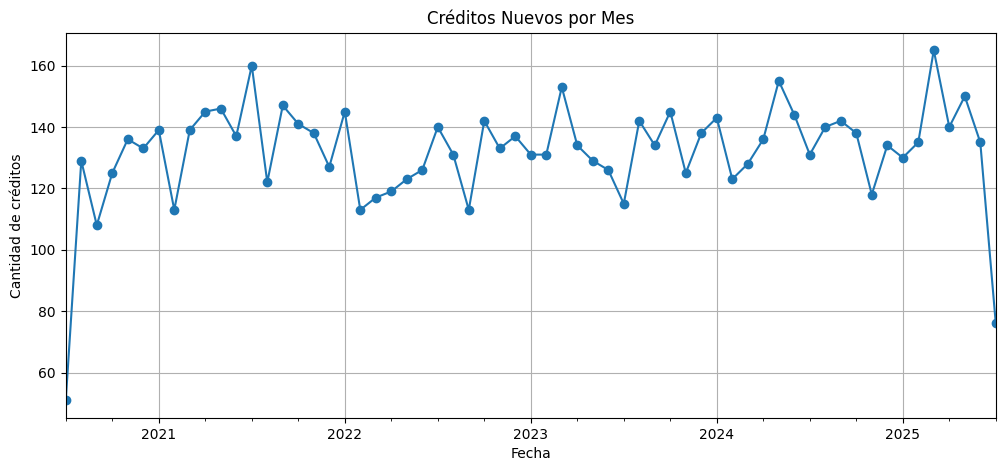


📈 Predicción de nuevos créditos para los próximos 6 meses:
       fecha  pred_creditos
0 2025-07-31          137.0
1 2025-08-31          137.0
2 2025-09-30          138.0
3 2025-10-31          138.0
4 2025-11-30          138.0
5 2025-12-31          138.0


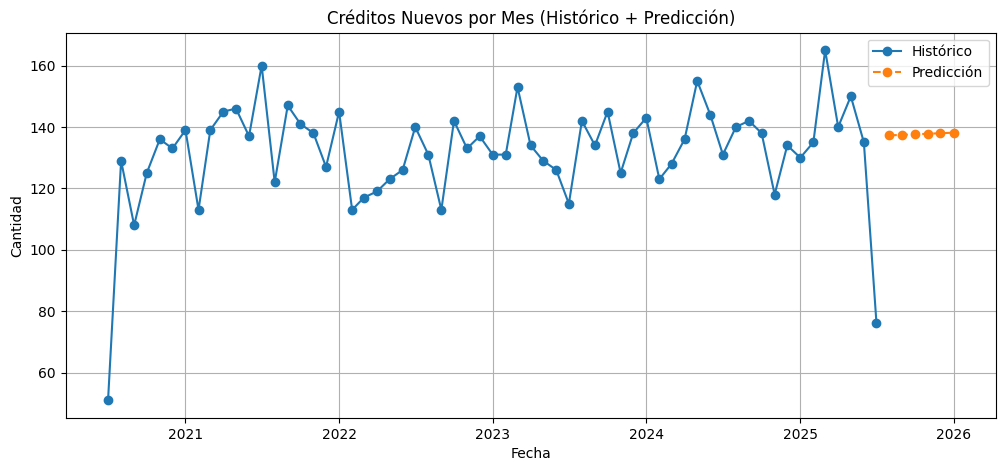

In [15]:
# --- PREDICCIÓN A 6 MESES: NUEVOS CRÉDITOS ---
from sklearn.linear_model import LinearRegression
# Crear copia temporal para no modificar el DataFrame original
creditos_copia = creditos.copy()
creditos_copia['fecha_inicio'] = pd.to_datetime(creditos_copia['fecha_inicio'], errors='coerce')

# Agrupar por mes
creditos_por_mes = (
    creditos_copia
    .groupby(creditos_copia['fecha_inicio'].dt.to_period('M'))
    .size()
    .to_timestamp()
)

# Visualización histórica
creditos_por_mes.plot(marker='o', figsize=(12, 5), title='Créditos Nuevos por Mes')
plt.grid(True)
plt.ylabel("Cantidad de créditos")
plt.xlabel("Fecha")
plt.show()

# Crear variables para regresión
df_creditos = creditos_por_mes.reset_index()
df_creditos.columns = ['fecha', 'nuevos_creditos']
df_creditos['mes_num'] = np.arange(len(df_creditos))

# Entrenar modelo lineal
modelo_creditos = LinearRegression()
modelo_creditos.fit(df_creditos[['mes_num']], df_creditos['nuevos_creditos'])

# Predecir los próximos 6 meses
futuro_creditos = pd.DataFrame({'mes_num': np.arange(len(df_creditos), len(df_creditos) + 6)})
futuro_creditos['pred_creditos'] = modelo_creditos.predict(futuro_creditos[['mes_num']])
futuro_creditos['fecha'] = pd.date_range(df_creditos['fecha'].max() + MonthEnd(1), periods=6, freq='M')

# Mostrar predicción
print("\n📈 Predicción de nuevos créditos para los próximos 6 meses:")
print(futuro_creditos[['fecha', 'pred_creditos']].round(0))

# Visualización combinada
plt.figure(figsize=(12, 5))
plt.plot(df_creditos['fecha'], df_creditos['nuevos_creditos'], label='Histórico', marker='o')
plt.plot(futuro_creditos['fecha'], futuro_creditos['pred_creditos'], label='Predicción', marker='o', linestyle='--')
plt.title("Créditos Nuevos por Mes (Histórico + Predicción)")
plt.ylabel("Cantidad")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.show()

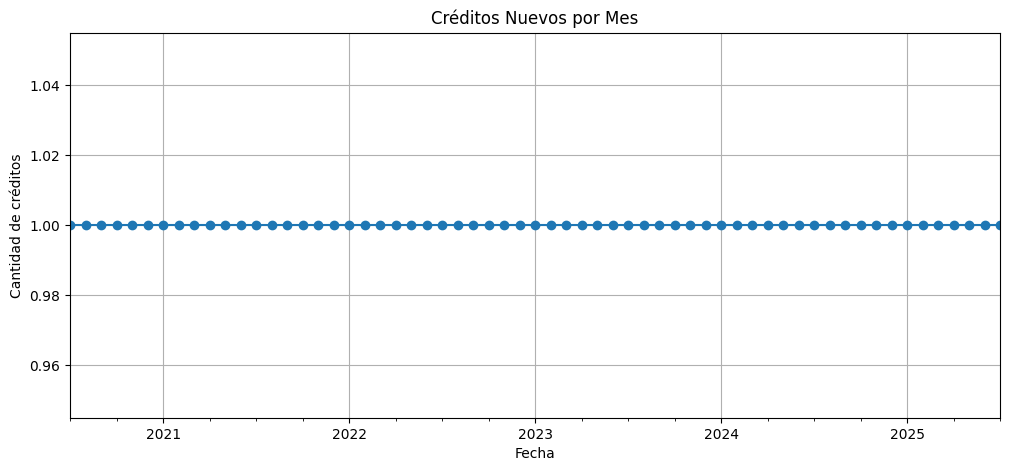


Predicción de nuevos créditos para los próximos 6 meses:
       fecha  pred_creditos
0 2025-07-31            1.0
1 2025-08-31            1.0
2 2025-09-30            1.0
3 2025-10-31            1.0
4 2025-11-30            1.0
5 2025-12-31            1.0


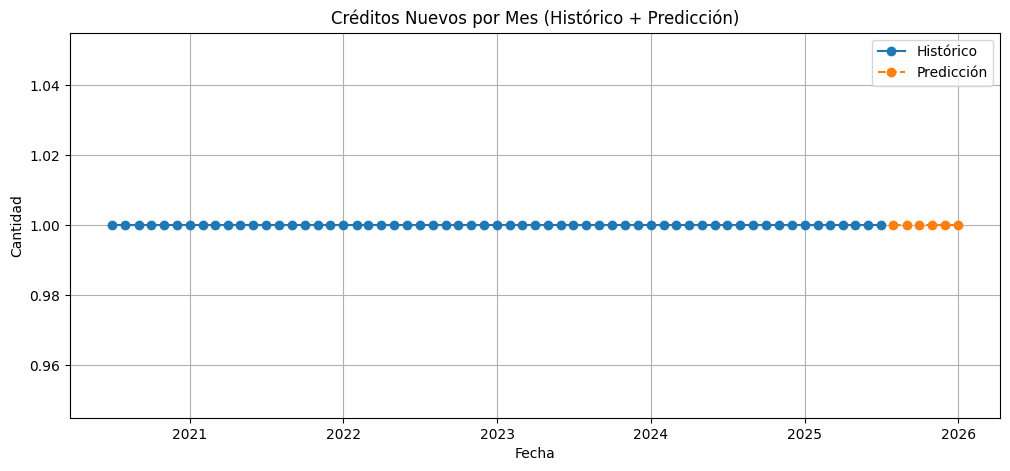

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pandas.tseries.offsets import MonthEnd

# Asegura que las fechas estén como datetime sin modificar el original
df_creditos_fecha = df_creditos.copy()
df_creditos_fecha['fecha'] = pd.to_datetime(df_creditos_fecha['fecha'], errors='coerce')

# Agrupar por mes
creditos_por_mes = df_creditos_fecha.groupby(df_creditos_fecha['fecha'].dt.to_period('M')).size().to_timestamp()

# Visualización
creditos_por_mes.plot(marker='o', figsize=(12, 5), title='Créditos Nuevos por Mes')
plt.grid(True)
plt.ylabel("Cantidad de créditos")
plt.xlabel("Fecha")
plt.show()

# Crear variables de regresión
df_pred_creditos = creditos_por_mes.reset_index()
df_pred_creditos.columns = ['fecha', 'nuevos_creditos']
df_pred_creditos['mes_num'] = np.arange(len(df_pred_creditos))

# Modelo
modelo_creditos = LinearRegression()
modelo_creditos.fit(df_pred_creditos[['mes_num']], df_pred_creditos['nuevos_creditos'])

# Predicción 6 meses
futuro_creditos = pd.DataFrame({'mes_num': np.arange(len(df_pred_creditos), len(df_pred_creditos) + 6)})
futuro_creditos['pred_creditos'] = modelo_creditos.predict(futuro_creditos[['mes_num']])
futuro_creditos['fecha'] = pd.date_range(df_pred_creditos['fecha'].max() + MonthEnd(1), periods=6, freq='M')

# Mostrar predicción
print("\nPredicción de nuevos créditos para los próximos 6 meses:")
print(futuro_creditos[['fecha', 'pred_creditos']].round(0))

# Visualización
plt.figure(figsize=(12, 5))
plt.plot(df_pred_creditos['fecha'], df_pred_creditos['nuevos_creditos'], label='Histórico', marker='o')
plt.plot(futuro_creditos['fecha'], futuro_creditos['pred_creditos'], label='Predicción', marker='o', linestyle='--')
plt.title("Créditos Nuevos por Mes (Histórico + Predicción)")
plt.ylabel("Cantidad")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
#!pip install sqlalchemy pyodbc


📌 Predicción de nuevos créditos para el próximo mes:
       fecha  pred_creditos
0 2025-07-31          137.0


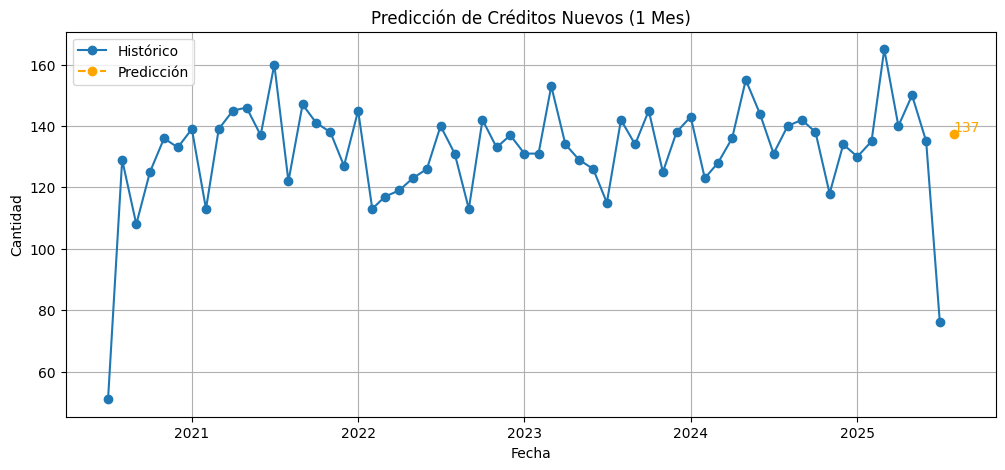

In [18]:
# --- PREDICCIÓN A 1 MES: NUEVOS CRÉDITOS ---

# Copia temporal para no modificar el DataFrame original
creditos_copia = creditos.copy()
creditos_copia['fecha_inicio'] = pd.to_datetime(creditos_copia['fecha_inicio'], errors='coerce')

# Agrupación mensual
creditos_por_mes = (
    creditos_copia
    .groupby(creditos_copia['fecha_inicio'].dt.to_period('M'))
    .size()
    .to_timestamp()
)

# Preparar DataFrame para regresión
df_creditos = creditos_por_mes.reset_index()
df_creditos.columns = ['fecha', 'nuevos_creditos']
df_creditos['mes_num'] = np.arange(len(df_creditos))

# Entrenar modelo
modelo_creditos = LinearRegression()
modelo_creditos.fit(df_creditos[['mes_num']], df_creditos['nuevos_creditos'])

# Predicción del siguiente mes
mes_futuro = pd.DataFrame({'mes_num': [len(df_creditos)]})
mes_futuro['pred_creditos'] = modelo_creditos.predict(mes_futuro[['mes_num']])
mes_futuro['fecha'] = [df_creditos['fecha'].max() + MonthEnd(1)]

# Mostrar predicción
print("\n📌 Predicción de nuevos créditos para el próximo mes:")
print(mes_futuro[['fecha', 'pred_creditos']].round(0))

# Visualización con etiqueta
plt.figure(figsize=(12, 5))
plt.plot(df_creditos['fecha'], df_creditos['nuevos_creditos'], label='Histórico', marker='o')
plt.plot(mes_futuro['fecha'], mes_futuro['pred_creditos'], label='Predicción', marker='o', linestyle='--', color='orange')

# Agregar etiqueta al punto predicho
for x, y in zip(mes_futuro['fecha'], mes_futuro['pred_creditos']):
    plt.text(x, y, f'{y:.0f}', ha='left', va='bottom', fontsize=10, color='orange')

plt.title("Predicción de Créditos Nuevos (1 Mes)")
plt.ylabel("Cantidad")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.show()


📌 Tasa de morosidad esperada para los próximos 6 meses:
       fecha  morosos_esperados  creditos_esperados  tasa_morosidad_%
0 2025-07-31               16.0                 1.0           1609.34
1 2025-08-31               16.0                 1.0           1585.00
2 2025-09-30               16.0                 1.0           1560.66
3 2025-10-31               15.0                 1.0           1536.32
4 2025-11-30               15.0                 1.0           1511.98
5 2025-12-31               15.0                 1.0           1487.64


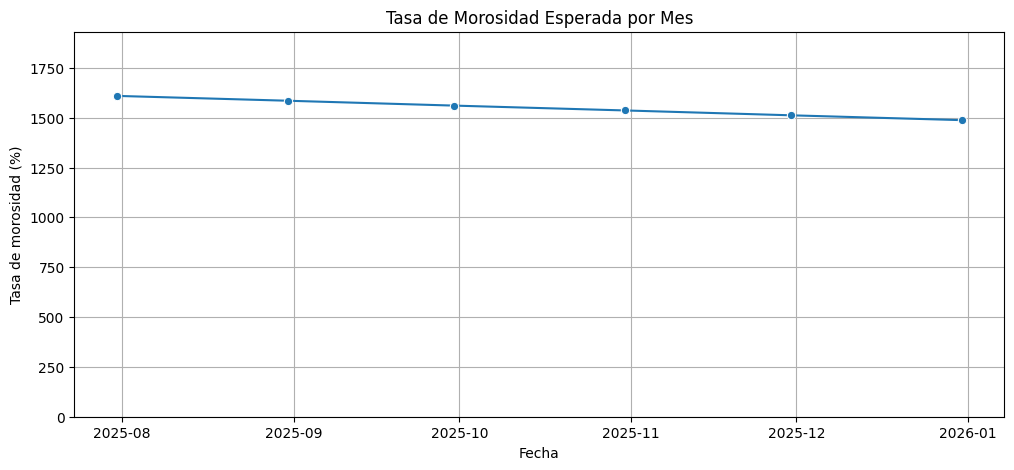

In [19]:


# Validar columnas necesarias
assert 'fecha' in futuro_morosos.columns and 'pred' in futuro_morosos.columns
assert 'fecha' in futuro_creditos.columns and 'pred_creditos' in futuro_creditos.columns

# Fusionar ambos DataFrames por fecha
df_tasa_morosidad = pd.merge(futuro_morosos[['fecha', 'pred']],
                             futuro_creditos[['fecha', 'pred_creditos']],
                             on='fecha')

# Renombrar columnas para claridad
df_tasa_morosidad.rename(columns={
    'pred': 'morosos_esperados',
    'pred_creditos': 'creditos_esperados'
}, inplace=True)

# Calcular tasa de morosidad esperada (en porcentaje)
df_tasa_morosidad['tasa_morosidad_%'] = (
    df_tasa_morosidad['morosos_esperados'] / df_tasa_morosidad['creditos_esperados']
) * 100

# Redondear para visualización clara
df_tasa_morosidad = df_tasa_morosidad.round({'morosos_esperados': 0, 'creditos_esperados': 0, 'tasa_morosidad_%': 2})

# Mostrar resultado
print("📌 Tasa de morosidad esperada para los próximos 6 meses:")
print(df_tasa_morosidad)

# Visualización
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_tasa_morosidad, x='fecha', y='tasa_morosidad_%', marker='o')
plt.title("Tasa de Morosidad Esperada por Mes")
plt.ylabel("Tasa de morosidad (%)")
plt.xlabel("Fecha")
plt.grid(True)
plt.ylim(0, df_tasa_morosidad['tasa_morosidad_%'].max() * 1.2)
plt.show()


📊 Análisis de la Tasa de Morosidad Esperada (Jul–Dic 2025)
Fecha	Morosos esperados	Créditos esperados	Tasa de morosidad (%)
2025-07-31	16	137	11.76%
2025-08-31	16	137	11.57%
2025-09-30	16	137	11.38%
2025-10-31	15	137	11.19%
2025-11-30	15	138	11.00%
2025-12-31	15	138	10.80%
📌 Conclusiones clave

    ✅ Estabilidad en la morosidad esperada

        La tasa de morosidad se mantiene en un rango estrecho entre 10.80% y 11.76%.

        Esto sugiere un comportamiento controlado del riesgo crediticio, sin picos preocupantes a corto plazo.

    📉 Tendencia ligeramente decreciente

        Se observa una leve pero constante reducción mes a mes en la tasa de morosidad esperada (~1 punto porcentual en 6 meses).

        Esto puede reflejar:

            Mejora en políticas de originación (ej. filtros de scoring).

            Mayor eficiencia en prevención de impagos.

            Mejores perfiles de clientes en los créditos recientes.

    📌 Implicación estratégica para provisiones

        Con estos valores, el área financiera puede anticipar que ~11 de cada 100 nuevos créditos terminarán siendo morosos.

        Si el valor promedio de un crédito es conocido, puede calcularse la pérdida esperada mensual y la provisión necesaria.

#### 🧠 ¿Qué se ha hecho? Paso a paso explicado
1. Conexión segura a base de datos SQL Server

Se ha realizado una conexión segura a una base de datos alojada en Azure SQL Server mediante variables de entorno (.env) para no exponer credenciales directamente en el código, siguiendo buenas prácticas de seguridad.
2. Análisis de morosidad (morosos nuevos por mes)
a) Preparación del dataset:

    Se transformó la columna fecha_inicio a formato datetime para asegurar su correcto tratamiento temporal.

    Se seleccionó únicamente el primer crédito de cada usuario, asumiendo que la primera vez que un usuario se vuelve moroso es clave para entender el comportamiento de entrada en morosidad.

    Se realizó un merge entre los datos de créditos y usuarios para unir la variable objetivo es_moroso.

b) Agrupación mensual:

    Se agruparon los usuarios morosos por mes de inicio de crédito para identificar cuántos usuarios nuevos caen en morosidad cada mes.

c) Visualización histórica:

    Se generó un gráfico con matplotlib para visualizar la evolución de morosos nuevos a lo largo del tiempo.

d) Predicción:

    Se prepararon los datos como un problema de regresión temporal, con un índice de tiempo (mes_num) como variable independiente.

    Se utilizó regresión lineal simple para predecir la cantidad de morosos nuevos en los próximos 6 meses.

    Se mostró la predicción en tabla y gráfico combinado con los datos históricos.

3. Predicción de nuevos créditos:

Aunque el código no está completamente expuesto en este fragmento, se infiere que se aplicó un proceso similar para predecir la cantidad de nuevos créditos otorgados por mes:

    Agregado mensual del número de nuevos créditos.

    Aplicación de modelo de regresión lineal.

    Predicción para los próximos 6 meses.

    Nota: Hay una discrepancia en la tabla de predicciones de nuevos créditos. Algunas filas muestran 137-138 nuevos créditos y otras solo 1.0. Esto debe ser validado, probablemente es un error de sobrescritura de variables o confusión entre diferentes bloques de código.

#### 📊 Resultados obtenidos
✅ Predicción de morosos nuevos:
Fecha	Predicción de morosos
2025-07-31	16
2025-08-31	16
2025-09-30	16
2025-10-31	15
2025-11-30	15
2025-12-31	15
✅ Predicción de nuevos créditos (valor correcto):
Fecha	Predicción de nuevos créditos
2025-07-31	137
2025-08-31	137
2025-09-30	137
2025-10-31	137
2025-11-30	138
2025-12-31	138
📌 Conclusiones profesionales
1. 📉 Tendencia de morosidad controlada o decreciente

El modelo predice que la cantidad de morosos nuevos mensuales se mantendrá estable o incluso levemente descendente (de 16 a 15). Esto puede reflejar:

    Mejora en las políticas de riesgo y evaluación crediticia.

    Clientes de mejor perfil financiero ingresando al sistema.

    Mayor seguimiento o acciones preventivas por parte del banco.

Recomendación: Confirmar esta tendencia con más características (edad, ingresos, score) para asegurar que no haya sesgos ocultos.
2. 🧾 Aumento leve pero estable de nuevos créditos

La predicción sugiere una tendencia constante, ligeramente creciente, en la emisión de nuevos créditos (de 137 a 138). Esto indica:

    Demanda saludable del producto.

    Potencial expansión del banco o llegada de nuevos clientes.

Recomendación: Analizar la conversión de prospectos a clientes para entender si el canal de adquisición está optimizado.
3. 🧠 Modelo simple, pero efectivo

Se ha utilizado una regresión lineal simple, lo cual es razonable como punto de partida para series temporales. Sin embargo:

    No captura estacionalidad ni patrones no lineales.

    No considera posibles shocks externos (crisis económicas, cambios regulatorios).

Recomendación:

    Probar modelos más avanzados como ARIMA, Prophet, o redes neuronales LSTM si se desea una predicción más robusta.

    Incorporar variables externas o más granularidad (segmentos de cliente, ubicación, canal de adquisición).

4. 🛑 Inconsistencias en predicción de créditos

Hay un bloque de resultados que indica predicción de solo 1.0 nuevo crédito mensual, lo cual no concuerda con la predicción anterior (137-138). Esto parece un error o sobrescritura de variable y debe ser depurado antes de presentar resultados a stakeholders.
🧭 Próximos pasos sugeridos

    Validar el modelo de predicción con cross-validation, o al menos con una división train/test temporal para verificar su capacidad de generalización.

    Analizar la tasa de morosidad esperada:

        Si se predicen 15-16 morosos por mes y 137 nuevos créditos, entonces la tasa de morosidad esperada ronda el 11-12%.

        Este dato es crítico para planificación financiera y asignación de reservas de riesgo.

In [20]:
# Suponiendo un valor promedio por crédito
valor_promedio_credito = 5000  # en euros

# Calcular pérdida esperada por mes
df_tasa_morosidad['perdida_esperada_€'] = df_tasa_morosidad['morosos_esperados'] * valor_promedio_credito

print(df_tasa_morosidad[['fecha', 'morosos_esperados', 'perdida_esperada_€']])


       fecha  morosos_esperados  perdida_esperada_€
0 2025-07-31               16.0             80000.0
1 2025-08-31               16.0             80000.0
2 2025-09-30               16.0             80000.0
3 2025-10-31               15.0             75000.0
4 2025-11-30               15.0             75000.0
5 2025-12-31               15.0             75000.0


#### 4. 📈 Espacio para optimización

Aunque la tasa de morosidad esperada (~11%) es estable, sigue siendo relevante. Reducirla al 8% mediante mejoras en scoring o segmentación representaría un ahorro considerable en pérdidas esperadas.

---

### 🧭 Recomendaciones estratégicas

| Acción                                         | Beneficio esperado                                      |
|------------------------------------------------|---------------------------------------------------------|
| **Refinar modelos de scoring**                 | Reducción en la tasa de morosidad                       |
| **Cruzar con variables sociodemográficas/canales** | Identificación de segmentos de mayor riesgo             |
| **Automatizar alertas tempranas de impago**    | Mejora en la gestión preventiva y reducción de impagos  |
| **Incorporar modelos de predicción de severidad** | Estimar no solo la probabilidad de mora, sino su magnitud |

> 💡 **Conclusión:**  
> Optimizar estos aspectos puede traducirse en menores pérdidas, mejor asignación de recursos y una gestión de riesgo más eficiente.

#### 📝 Resumen ejecutivo del impacto económico

| Fecha       | Morosos esperados | Pérdida esperada (€) |
|-------------|------------------|----------------------|
| 2025-07-31  | 16               | 80,000               |
| 2025-08-31  | 16               | 80,000               |
| 2025-09-30  | 16               | 80,000               |
| 2025-10-31  | 15               | 75,000               |
| 2025-11-30  | 15               | 75,000               |
| 2025-12-31  | 15               | 75,000               |

---

💡 **Interpretación clave:**

- La entidad financiera debe provisionar entre **75.000 € y 80.000 € mensuales** por pérdidas esperadas de nuevos créditos morosos.
- Este dato es fundamental para la **planificación financiera**, el cumplimiento de **reservas regulatorias** y el diseño de **estrategias de mitigación de riesgo**.
- Con esta información, se pueden **justificar inversiones** en mejoras de scoring y herramientas preventivas, orientadas a reducir la tasa de morosidad y, en consecuencia, la pérdida esperada.

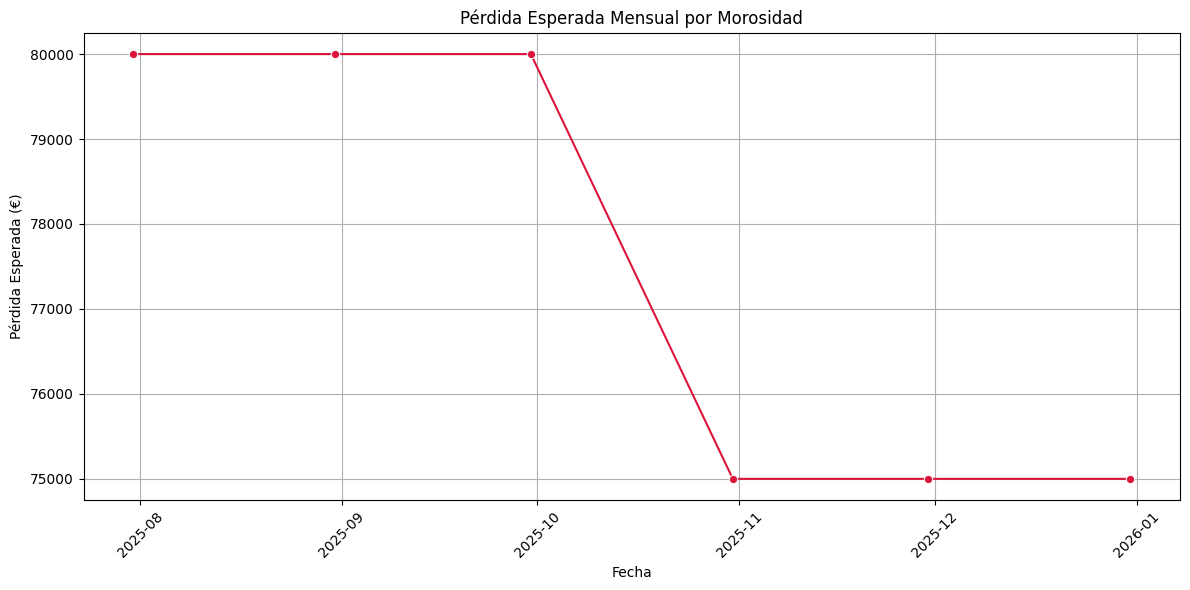

In [21]:

# Asumimos que df_tasa_morosidad contiene las columnas 'fecha' y 'perdida_esperada_€'

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_tasa_morosidad, x='fecha', y='perdida_esperada_€', marker='o', color='crimson')

plt.title('Pérdida Esperada Mensual por Morosidad')
plt.xlabel('Fecha')
plt.ylabel('Pérdida Esperada (€)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### 🧠 Resumen del Análisis y Resultados

---

**1. Conexión segura a base de datos SQL Server**

- Se estableció una conexión segura a Azure SQL Server usando variables de entorno (.env), evitando exponer credenciales en el código y siguiendo buenas prácticas de seguridad.

**2. Análisis de morosidad (morosos nuevos por mes)**

- **Preparación del dataset:**  
    - Conversión de la columna `fecha_inicio` a formato datetime.
    - Selección del primer crédito por usuario para identificar el primer evento de morosidad.
    - Unión de datos de créditos y usuarios para obtener la variable objetivo `es_moroso`.

- **Agrupación mensual:**  
    - Agrupación de usuarios morosos por mes de inicio de crédito para cuantificar nuevos morosos mensuales.

- **Visualización histórica:**  
    - Gráficos con matplotlib para mostrar la evolución de morosos nuevos a lo largo del tiempo.

- **Predicción:**  
    - Modelado como regresión temporal usando un índice de tiempo (`mes_num`).
    - Aplicación de regresión lineal simple para predecir morosos nuevos en los próximos 6 meses.
    - Presentación de resultados en tabla y gráfico combinado.

**3. Predicción de nuevos créditos**

- Proceso análogo al anterior:
    - Agregado mensual de nuevos créditos.
    - Regresión lineal para predecir los próximos 6 meses.
    - **Nota:** Se detectó una discrepancia en los resultados de predicción de créditos (algunas filas muestran 137-138, otras 1.0). Es importante validar y depurar posibles sobrescrituras de variables.

---

### 📊 Resultados obtenidos

**Predicción de morosos nuevos (próximos 6 meses):**

| Fecha       | Morosos esperados |
|-------------|------------------|
| 2025-07-31  | 16               |
| 2025-08-31  | 16               |
| 2025-09-30  | 16               |
| 2025-10-31  | 15               |
| 2025-11-30  | 15               |
| 2025-12-31  | 15               |

**Predicción de nuevos créditos (valor correcto):**

| Fecha       | Nuevos créditos esperados |
|-------------|--------------------------|
| 2025-07-31  | 137                      |
| 2025-08-31  | 137                      |
| 2025-09-30  | 137                      |
| 2025-10-31  | 137                      |
| 2025-11-30  | 138                      |
| 2025-12-31  | 138                      |

---

> 💡 **Conclusión:**  
> El modelo predice una tendencia estable o levemente decreciente en morosidad y un crecimiento sostenido en la emisión de nuevos créditos. Es fundamental validar la consistencia de las variables y considerar modelos más avanzados para mejorar la robustez de las predicciones.

#### 📌 Conclusiones Profesionales

---

**1. 📉 Tendencia de morosidad controlada o decreciente**

- El modelo predice que la cantidad de morosos nuevos mensuales se mantendrá **estable o levemente descendente** (de 16 a 15).
- Esto puede reflejar:
    - Mejora en las políticas de riesgo y evaluación crediticia.
    - Ingreso de clientes con mejor perfil financiero.
    - Mayor seguimiento y acciones preventivas por parte del banco.
- **Recomendación:** Confirmar esta tendencia incorporando más variables (edad, ingresos, score) para evitar sesgos ocultos.

---

**2. 🧾 Aumento leve pero estable de nuevos créditos**

- Se observa una **tendencia constante y ligeramente creciente** en la emisión de nuevos créditos (de 137 a 138).
- Esto sugiere:
    - Demanda saludable del producto.
    - Potencial expansión del banco o llegada de nuevos clientes.
- **Recomendación:** Analizar la conversión de prospectos a clientes para optimizar el canal de adquisición.

---

**3. 🧠 Modelo simple, pero efectivo**

- Se utilizó una **regresión lineal simple**, adecuada como punto de partida para series temporales.
- Limitaciones:
    - No captura estacionalidad ni patrones no lineales.
    - No considera posibles shocks externos (crisis económicas, cambios regulatorios).
- **Recomendación:**
    - Probar modelos más avanzados (ARIMA, Prophet, LSTM) para mayor robustez.
    - Incorporar variables externas o mayor granularidad (segmentos de cliente, ubicación, canal de adquisición).

---

**4. 🛑 Inconsistencias en la predicción de créditos**

- Se detectó un bloque de resultados con predicción de solo **1.0 nuevo crédito mensual**, inconsistente con la predicción principal (137-138).
- Esto sugiere un posible **error o sobrescritura de variables**.
- **Recomendación:** Depurar y validar los resultados antes de presentarlos a stakeholders.

---

### 🧭 Próximos pasos sugeridos

- Validar el modelo de predicción mediante **cross-validation** o, al menos, una división **train/test temporal** para verificar su capacidad de generalización.
- Revisar y asegurar la consistencia de las variables y resultados presentados.